# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#2 : Pre-processing**

The goal here is to iteratively find the best pre-processing pipeline based on a simple basic machine learning model, adding/removing steps along the way

##### #2.1 : Importing and splitting data

In [1]:
# Read the train and test files
import pandas as pd
import re

metadata = open("data/census_income_metadata.txt")
col_names = [re.findall("\(([^\)]+)\)", line)[0] for line in metadata.readlines()[81:121]]
col_names.append("total person income")

train = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)
test = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)

data=pd.concat([train, test], ignore_index=True)

e:\dataiku_assessment\venv\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [2]:
# Split datasets into features set and target variable
# Note : target classes "-50k" and ">50k" will respectively be labelled 0 and 1
X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]
y_train = train.iloc[:, -1].map(lambda s: 0 if "-" in s else 1)
y_test = test.iloc[:, -1].map(lambda s: 0 if "-" in s else 1)

In [3]:
# Define numerical columns and categorical columns
num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year"]
cat_cols = [col for col in X_train.columns if col not in num_cols]

##### #2.2 : Basic pre-processing operations

To evaluate our pre-processing choices in this section, we will use a baseline Logistic Regression model for comparison. Other than being able to quickly compare different pre-processing pipeline, these kind of models are among the most inferential ones and will allow us to be able to identify important features for prediction

For our first basic preprocessing pipeline, we will :
- Drop columns with >40% NaN Values (migration related)
- Impute NaN values with most frequent class for other columns (country of birth, hispanic origin, state of previous residence)
- Use Ordinal Encoding for categorical features. The reason for not using one hot encoding for the time being is that we want to be able to identify meaningful features
- Use standard scaling to standardize our numerical features

In [4]:
# Defining basic preprocessing steps
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

cols_to_drop = ['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt']
categorical_cols = [col for col in cat_cols if col not in cols_to_drop]
numerical_cols = num_cols

categories = [data[col].unique() for col in categorical_cols]

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=categories))
])

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("dropper", "drop", cols_to_drop),
    ("categorical", cat_transformer, categorical_cols),
    ("numerical", num_transformer, numerical_cols)
])

In [5]:
# Creating baseline model
from sklearn.linear_model import LogisticRegression
lr_classif = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=5000, random_state=42))
])

In [6]:
# Define evaluation procedure for both models
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(clf, curves=True):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    if curves:
        N, train_score, val_score = learning_curve(clf, X_train, y_train, scoring="f1")
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label="train score")
        plt.plot(N, val_score.mean(axis=1), label="val score")
        plt.legend()


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     93576
           1       0.72      0.25      0.37      6186

    accuracy                           0.95     99762
   macro avg       0.84      0.62      0.67     99762
weighted avg       0.94      0.95      0.94     99762



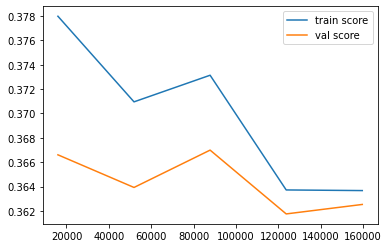

In [7]:
evaluate_model(lr_classif)

- While the f1-score is not too bad on the major class (under 50k incomes), is it quite poor for the minor class (over 50k)
- From the curves, we can see that the model is clearly underfitting. We will therefore perform some feature engineering to adress this issue

##### #2.3 : Feature Engineering

In [158]:
feature_importance = pd.DataFrame(data=lr_classif["classifier"].coef_.transpose(), index=[col for col in X_train.columns if col not in cols_to_drop], columns=["coef"])
feature_importance["abs"] = abs(feature_importance["coef"])
feature_importance.sort_values("abs", ascending=False)

,coef,abs
age,-3.061303,3.061303
year,1.305765,1.305765
weeks worked in year,1.162231,1.162231
class of worker,-0.939074,0.939074
veterans benefits,0.711596,0.711596
fill inc questionnaire for veteran's admin,0.626412,0.626412
own business or self employed,0.477571,0.477571
citizenship,0.361747,0.361747
country of birth self,0.350157,0.350157
detailed industry recode,-0.326056,0.326056


In [184]:
for k in [5, 10, 15, 20, 25, 30, 35]:
    top_k_features = feature_importance.iloc[:k].index
    cols_to_drop_with_fs = [col for col in X_train.columns if col not in top_k_features]
    categorical_cols_with_fs = [col for col in cat_cols if col not in cols_to_drop]
    numerical_cols_with_fs = [col for col in num_cols if col not in cols_to_drop]

    categories = [data[col].unique() for col in categorical_cols]

    cat_transformer_with_fs  = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(categories=categories))
    ])

    preprocessor_with_fs = ColumnTransformer(transformers=[
        ("dropper", "drop", cols_to_drop),
        ("categorical", cat_transformer_with_fs, categorical_cols),
        ("numerical", num_transformer, numerical_cols_with_fs)
    ])


    lr_classif_with_fs = Pipeline(steps=[
        ("preprocessor", preprocessor_with_fs),
        ("classifier", LogisticRegression(max_iter=5000, random_state=42))
    ])

    print(f"====== Model with top {k} features ======")
    evaluate_model(lr_classif_with_fs, curves=False)

====== Model with top 5 features ======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93576
           1       0.39      0.02      0.03      6186

    accuracy                           0.94     99762
   macro avg       0.67      0.51      0.50     99762
weighted avg       0.91      0.94      0.91     99762

====== Model with top 10 features ======
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93576
           1       0.45      0.05      0.10      6186

    accuracy                           0.94     99762
   macro avg       0.70      0.53      0.53     99762
weighted avg       0.91      0.94      0.91     99762

====== Model with top 15 features ======
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     93576
           1       0.52      0.09      0.15      6186

    accuracy                           0.94     99762
   mac

Simply removing features does not seem to do the trick

In [212]:
from sklearn.decomposition import PCA
pca = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=10))
])
pca.fit(X_train)
cols_to_drop = ['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt']
pca_results = pd.DataFrame(pca["pca"].components_, columns=[col for col in X_train.columns if col not in cols_to_drop], index=[f"PC-{k+1}" for k in range(len(pca["pca"].components_))])
pca_results["explained variance"] = pca["pca"].explained_variance_
pd.set_option('display.max_columns', 500)
pca_results.head(10)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,live in this house 1 year ago,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,explained variance
PC-1,0.058853,0.640326,0.657026,-0.009182,0.000253,0.011692,0.343740,0.172347,-0.003013,-0.004256,0.003199,0.005630,0.003740,0.023960,0.034661,0.001022,0.009598,-0.012318,-0.010556,0.000431,-0.017904,-0.015017,-0.010939,0.007087,0.001053,0.004638,-0.000142,-0.012267,0.000049,0.009843,0.011132,0.004082,0.004997,0.000398,0.036194,0.045567,258.534735
PC-2,-0.000037,0.008344,0.012721,0.042870,0.000020,0.002124,0.000640,0.000421,0.009301,0.032963,-0.000297,-0.000492,0.000547,-0.001797,0.004060,0.000088,-0.023177,0.005815,-0.005498,-0.001106,-0.005045,0.649231,0.621619,0.432396,0.033655,-0.001420,-0.000063,-0.003349,-0.000839,0.008750,-0.001344,0.000251,0.000058,-0.000447,-0.001278,-0.000338,82.841220
PC-3,-0.004167,0.700125,-0.701406,-0.011604,-0.001524,-0.000519,0.087239,-0.099551,0.003001,0.004436,-0.001604,0.001003,0.000079,-0.000495,-0.002699,-0.000857,-0.005852,0.001563,0.000710,0.000228,0.000398,0.005886,-0.001664,0.001053,0.001003,-0.001132,-0.000002,0.000512,-0.000014,-0.000191,0.005473,-0.003216,-0.002148,-0.001340,0.003623,-0.000460,53.655816
PC-4,0.001268,-0.004669,-0.012722,-0.000796,0.001014,-0.001091,0.005553,0.003777,0.003712,-0.000490,-0.000096,-0.000314,0.002955,-0.009654,-0.003535,0.086606,0.995087,0.026115,0.004493,0.003649,0.001556,0.008404,0.013483,0.021691,0.001611,0.002370,-0.000124,0.000180,0.018528,-0.011603,-0.000879,-0.001352,-0.000931,-0.002281,0.002060,-0.000028,41.661208
PC-5,-0.004068,0.016728,0.007255,0.992952,0.002533,-0.005628,0.004633,-0.042406,0.006551,0.033561,0.003624,-0.002181,0.003064,-0.008493,-0.017786,0.000169,0.001606,0.004673,-0.016108,0.000093,0.002253,-0.004487,-0.089437,0.032254,0.012264,-0.000996,0.000119,-0.011503,-0.000328,0.014655,-0.007169,0.007542,0.002537,0.001782,-0.010777,-0.013146,17.571836
PC-6,-0.043768,0.234969,0.172676,-0.020562,-0.005998,-0.003520,-0.671598,-0.120593,-0.006976,0.046353,0.016504,-0.004226,-0.004520,-0.019095,-0.032334,-0.000140,0.017360,-0.108405,-0.020238,0.002473,0.015212,0.484761,-0.268179,-0.347765,-0.022702,-0.005953,0.000365,0.013399,0.001844,-0.005293,-0.008165,0.001504,0.002509,0.000830,-0.025996,-0.031837,12.682867
PC-7,-0.031983,0.201422,0.137938,0.012426,-0.004006,0.003447,-0.591580,-0.113506,0.005197,-0.057861,0.012668,-0.002986,-0.004548,-0.016404,-0.022537,0.000224,0.000492,-0.063093,-0.012466,-0.000742,0.005721,-0.569685,0.354537,0.341153,0.019569,-0.004115,0.000320,0.006477,-0.000439,-0.001000,-0.005839,0.001963,0.001904,0.000943,-0.016568,-0.021262,12.455528
PC-8,0.002095,0.009406,0.005799,-0.082993,-0.001654,0.006509,-0.063458,0.009527,0.009308,0.040943,-0.002423,-0.000058,0.001365,0.001837,-0.006563,0.002144,-0.010847,0.082353,0.004280,-0.000465,-0.002104,0.108449,-0.635242,0.747871,0.073116,-0.000378,-0.000362,-0.002097,-0.000282,-0.007803,-0.000087,-0.004122,-0.002914,-0.003693,0.002893,0.003825,10.742415
PC-9,-0.016195,0.046455,0.037096,0.000620,-0.001206,-0.054399,-0.102932,-0.006625,0.015897,0.011242,-0.021075,-0.001425,0.003127,-0.004155,-0.002911,0.003173,-0.024052,0.985113,0.024988,-0.004248,0.023775,0.002290,0.043282,-0.081648,-0.007959,-0.001018,-0.000515,0.001802,-0.001358,-0.010917,-0.001745,-0.013441,-0.011140,-0.002598,-0.011150,-0.018063,9.912188
P

<AxesSubplot:>

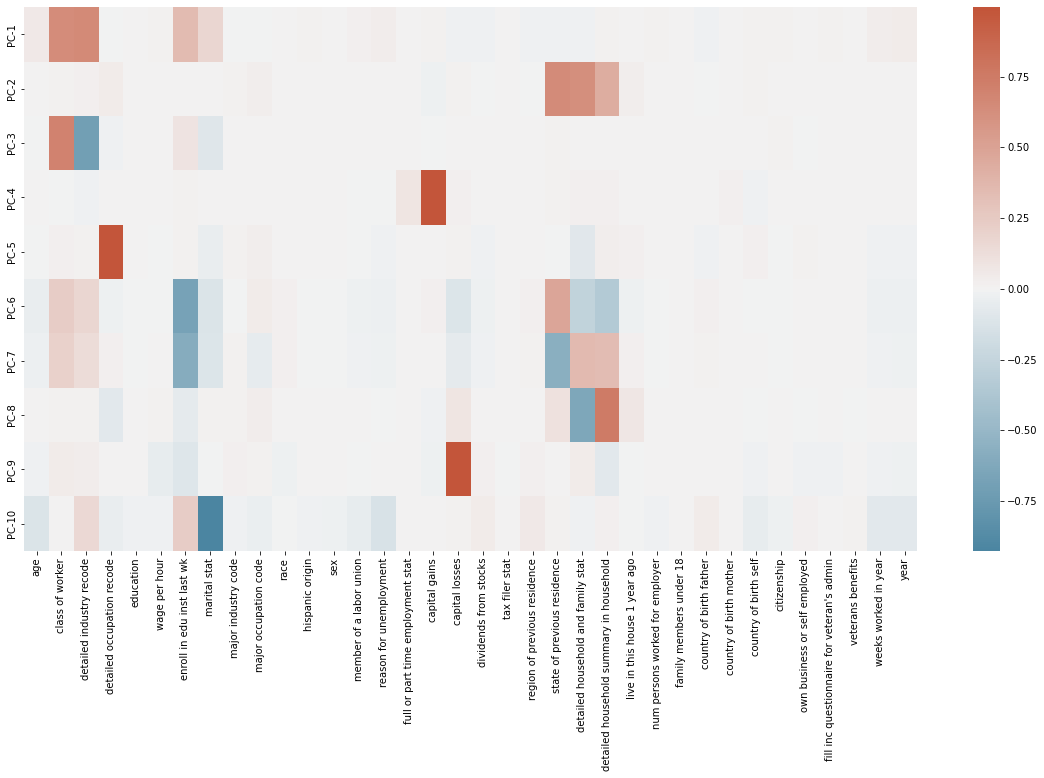

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sns.set_theme
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pca_results.iloc[:, :-1], cmap=cmap, center=0)

In [231]:
cols_to_keep_pca = ["class of worker", "detailed industry recode", "enroll in edu inst last wk", "state of previous residence", "detailed household nd family stat"]
cols_to_drop_pca = [col for col in X_train.columns if col not in cols_to_keep_pca]
categorical_cols_pca = [col for col in cat_cols if col not in cols_to_drop]
numerical_cols_pca = [col for col in num_cols if col not in cols_to_drop]

categories_pca = [data[col].unique() for col in categorical_cols_pca]

cat_transformer_pca = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=categories_pca))
])

num_transformer_pca = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("dropper", "drop", cols_to_drop),
    ("categorical", cat_transformer, categorical_cols_pca),
    ("numerical", num_transformer, numerical_cols_pca)
])

lr_classif_pca = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=25)),
    ("classifier", LogisticRegression(max_iter=5000, random_state=42))
])

evaluate_model(lr_classif_pca, curves=False)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     93576
           1       0.71      0.22      0.34      6186

    accuracy                           0.95     99762
   macro avg       0.83      0.61      0.65     99762
weighted avg       0.94      0.95      0.93     99762



PCA does not work very well (not improving score, especially with low number of components)

In [189]:
pca.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('dropper', 'drop',
                                    ['migration code-change in msa',
                                     'migration code-change in reg',
                                     'migration code-move within reg',
                                     'migration prev res in sunbelt']),
                                   ('categorical',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder',
                                                     OrdinalEncoder(categories=[array(['Not in universe', 'Self-employed-not incorporated', 'Privat...
                                     'country of birth father',
                                     'country of birth mother',
                                     'country of birth self', 'cit

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
lr_classif_with_fs = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", SelectFromModel(LinearSVC())),
    ("classifier", LogisticRegression(max_iter=5000, random_state=42))
])
evaluate_model(lr_classif_with_fs, curves=False)

e:\dataiku_assessment\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     93576
           1       0.77      0.15      0.25      6186

    accuracy                           0.94     99762
   macro avg       0.86      0.57      0.61     99762
weighted avg       0.94      0.94      0.93     99762



In [139]:
fs.coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'